In [2]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from notebook_utils import get_audio_list
import numpy as np
import tensorflow as tf

2021-07-31 23:46:03.085118: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Dataset de paths

In [3]:
rirs_path = '/home/martin/deep-dereverb/data/rir_aumentacion/aumentados/'
speechs_path = '/home/martin/deep-dereverb/data/speech/'
rir_list , speech_list = map(get_audio_list, [rirs_path, speechs_path])

In [4]:
records_list = []
for speech in speech_list:
    rir = np.random.choice(rir_list)
    records_list.append([speech,rir])

In [6]:
in1, fs = librosa.load(records_list[0][0], sr=None)
in2, fs = librosa.load(records_list[62][1], sr=None)

in1 = tf.convert_to_tensor(in1)
in1 = tf.convert_to_tensor(in1)

Audio(in1, rate=fs)

# Convolucion en Tensorflow

In [7]:
# in1=speech - in2=rir

s1 = tf.shape(in1)
s2 = tf.shape(in2)
final_shape = s1+s2-1

sp1 = tf.signal.rfft(in1, final_shape)
sp2 = tf.signal.rfft(in2, final_shape)
ret = tf.signal.irfft(sp1*sp2, final_shape)

crop = ret[:s1[-1]]

assert tf.shape(in1) == tf.shape(crop)
#def chunk():

2021-07-31 23:47:35.398169: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-07-31 23:47:36.305693: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-31 23:47:36.844017: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


In [8]:
Audio(tf.squeeze(crop).numpy(), rate=16000)

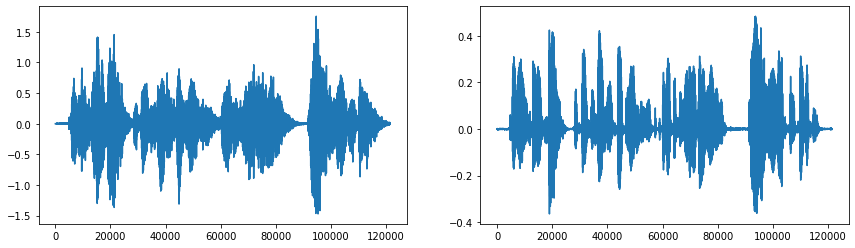

In [9]:
plt.subplot(1,2,1)
plt.plot(tf.squeeze(crop).numpy())

plt.subplot(1,2,2)
plt.plot(tf.squeeze(in1).numpy())
plt.subplots_adjust(right=2)

In [10]:
def tf_convolve(in1, in2):
    # in1=speech, in2=RIR
    s1 = tf.shape(in1)
    s2 = tf.shape(in2)
    final_shape = s1+s2-1
    #import pdb; pdb.set_trace()
    sp1 = tf.signal.rfft(in1, final_shape[0])
    sp2 = tf.signal.rfft(in2, final_shape[0])
    ret = tf.signal.irfft(sp1*sp2, final_shape)

    crop = tf.squeeze(ret[:s1[-1]])
    return crop

def load_audio(path):
    # Cargo los audios
    audio = tf.io.read_file(path)
    audio, sample_rate = tf.audio.decode_wav(audio, desired_channels=1, desired_samples=-1)
    return audio

def load_audio(paths):
    speech_path = paths[0]
    rir_path = paths[1]
    
    # Cargo los audios
    speech_read = tf.io.read_file(speech_path)
    rir_read = tf.io.read_file(rir_path)
    speech_audio, _ = tf.audio.decode_wav(speech_read, desired_channels=1, desired_samples=-1)
    rir_audio, _ = tf.audio.decode_wav(speech_read, desired_channels=1, desired_samples=-1)
    
    # Convoluciono
    reverb = tf_convolve(speech_audio, rir_audio)
    speech = tf.squeeze(speech_audio)
    return speech, reverb

In [14]:
load_audio(asd)

TypeError: 'numpy.int32' object is not iterable

# Tensorflow Data API

In [12]:
filepath_ds = tf.data.Dataset.from_tensor_slices(records_list)


In [13]:
for item in filepath_ds.take(1):
    asd = item
    print(item)

tf.Tensor(
[b'/home/martin/deep-dereverb/data/speech/speech_1614.wav'
 b'/home/martin/deep-dereverb/data/rir_aumentacion/aumentados/243.wav'], shape=(2,), dtype=string)
